In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from omegaconf import OmegaConf
import hydra
import sys
import einops
sys.path.append('../')
import matplotlib.pyplot as plt
import math
from src.datasets import SequenceImageTransitionDataset
from src.patch_vae import PatchVAE
from src.vqvae import VQVAE
from src.patch_utils import  plot_image_patches, patches_to_image, image_to_patches
from src.mask_utils import make_gt_causal_mask, aggreg_heads
from src.dynamics_model import AttentionDynamicsModel
from src.small_patch_encoder import SmallPatchEncoder
import pandas as pd
import cv2

In [7]:
folder_data = "2023.01.10"
folder_time = "190733"
model_name = "patch_vae"


In [8]:
config_path = f"../outputs/dynamics/{model_name}/{folder_data}/{folder_time}/.hydra/config.yaml"
config = OmegaConf.load(config_path)
config["env"]["num_transitions"] = 500

In [10]:
data_path = "../data/expert_visual_{}transitions_{}_{}_{}_{}{}no_targets.npz".format(config["env"]["num_transitions"],config["env"]["num_sprites"],("all_sprite_mover"if config["env"]["all_sprite_mover"] else  "discrete_all_sprite_mover" if config["env"]["discrete_all_sprite_mover"] else "select_move"),config["env"]["random_init_places"],config["env"]["num_action_repeat"],"instantmove" if config["env"].get("instant_move",False) else "")
#data_path = "/cluster/home/gboeshertz/patch_rl/data/visual_180transitions_4_all_sprite_mover_False_4instantmove.npz"
print(data_path)
dataset = SequenceImageTransitionDataset(data_path=data_path)



../data/expert_visual_500transitions_4_all_sprite_mover_True_4instantmoveno_targets.npz
torch.Size([500, 1, 128, 128, 3])
reward -0.009999999776482582 has 422 transitions
reward 0.25 has 73 transitions
reward 0.5 has 5 transitions


In [13]:
dataset.actions 

tensor([[-1.,  1., -1.,  ..., -1., -1.,  1.],
        [-1.,  1.,  1.,  ..., -1., -1.,  1.],
        [-1.,  1.,  1.,  ..., -1., -1.,  1.],
        ...,
        [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1.,  1.,  1.,  ..., -1.,  1., -1.],
        [ 1.,  1.,  1.,  ..., -1.,  1., -1.]])

In [57]:
image,action, next_image,_ =  dataset[0]#80
image.shape

torch.Size([5, 3, 128, 128])

In [58]:
spe = SmallPatchEncoder([[255,0,0],[0,255,0],[0,0,255],[255,255,255]],patch_size=4,background_color=[0,0,0],
                        image_size=128)

In [59]:
x = torch.Tensor(image)

In [60]:
new = cv2.resize(image[0].permute(1,2,0).numpy(),(128,128))

In [61]:
patches = spe.get_encoding_for_dynamics(torch.from_numpy(new).permute(2,0,1).unsqueeze(0).float())
import math

In [62]:
decoded_images = spe.decode(patches)

torch.Size([1, 1024, 3])
torch.Size([1, 1024, 3, 4, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


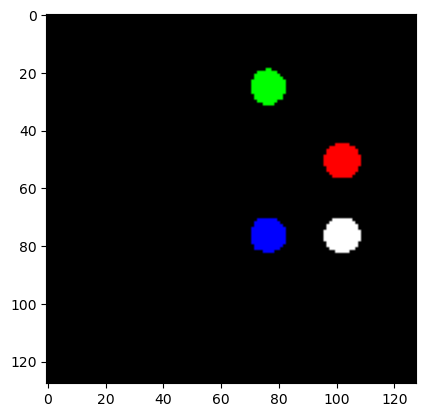

In [63]:
plt.imshow(new)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


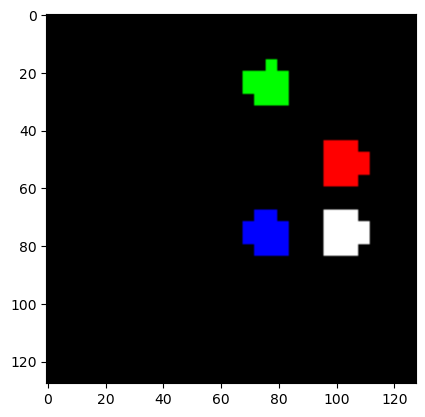

In [64]:
plt.imshow(decoded_images[0].permute(1,2,0).numpy())

In [65]:
import src.mask_utils
from src.mask_utils import gt_reward_function

In [66]:
#enc_dec_path = "/cluster/home/gboeshertz/patch_rl/outputs/patch_model/patch_vae/2023.01.05/100944/best_val_encoder_decoder.pt"#config["encoder_decoder_path"]
import os 
#onfig["encoder_decoder_path"]= enc_dec_path
encoder_decoder_conf = OmegaConf.load(os.path.join(os.path.dirname(config["encoder_decoder_path"]), ".hydra/config.yaml"))["encoder_decoder"]
#
config["encoder_decoder"] = encoder_decoder_conf
print(encoder_decoder_conf)
enc_dec = hydra.utils.instantiate(config["encoder_decoder"]) #PatchVAE(**config["model"]["patch_vae"])

er = enc_dec.load_state_dict(torch.load(config["encoder_decoder_path"],map_location=torch.device('cpu')))
enc_dec.eval();

{'name': 'patch_vae', '_target_': 'src.patch_vae.PatchVAE', 'patch_size': 16, 'in_channels': 3, 'embed_dim': 64, 'channels': [64, 128, 256], 'kernel_sizes': [3, 3, 3], 'paddings': [1, 1, 1], 'strides': [2, 2, 2], 'kld_weight': 0.001, 'loss_type': 'B', 'gamma': 30.0, 'max_capacity': 30, 'Capacity_max_iter': 500000, 'beta': 4, 'norm_type': 'gn'}


In [67]:
p_image = image/255.
recons_image = enc_dec.reconstruct_image(p_image)


In [68]:
from moog_demos.example_configs.bouncing_sprites import get_config

In [69]:
get_config(3)

Using bouncing ball environment with 3 sprites
<PIL.Image.Image image mode=RGB size=128x128 at 0x2B5AAC086FD0>


{'state_initializer': <function moog_demos.example_configs.bouncing_sprites.get_config.<locals>.state_initializer()>,
 'physics': <moog.physics.physics.Physics at 0x2b5aac3b49a0>,
 'task': <moog.tasks.composite_task.CompositeTask at 0x2b5aac078fa0>,
 'action_space': <moog.action_spaces.select_move.SelectMove at 0x2b5aac086be0>,
 'observers': {'image': <moog.observers.pil_renderer.PILRenderer at 0x2b5aac086880>,
  'sprite_info': <moog.observers.sprites_infos.SpriteInfo at 0x2b5aac086fa0>}}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


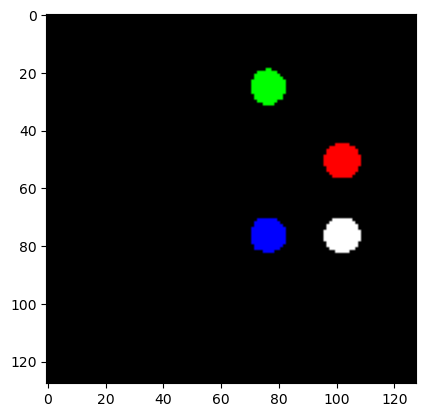

In [70]:
plt.imshow(image[0].permute(1,2,0).numpy())

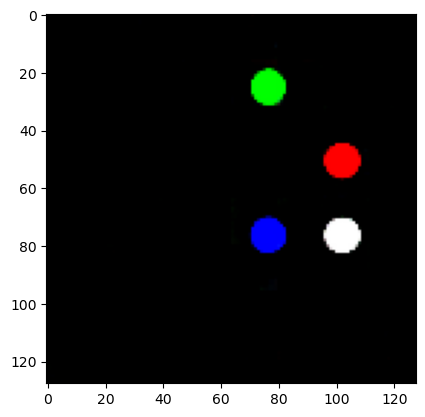

In [71]:
plt.imshow((recons_image[0].permute(1,2,0)*255).byte())

In [93]:
model_info = "best_val"

#dynamics_model_path = f"../outputs/dynamics/{model_name}/{folder_data}/{folder_time}/{model_info}_dynamics.pt"
dynamics_model_path = f"../outputs/dynamics/{model_name}/{folder_data}/{folder_time}/early_stopped1.pt"

config["dynamics"]["num_patches"] = enc_dec.num_patches
config["dynamics"]["action_dim"] = action.shape[-1]
config["dynamics"]["in_features"] = enc_dec.embed_dim
config["dynamics"]["num_actions"] = config["env"]["num_sprites"]
config["dynamics"]["num_rewards"] = 3


dynamics_model = hydra.utils.instantiate(config["dynamics"])
dynamics_model.load_state_dict(torch.load(dynamics_model_path,map_location=torch.device('cpu')))
dynamics_model.eval();

Creating MLP with input size 256 and output size 64
Creating MLP with layer sizes [256]
Creating MLP with input size 256 and output size 3
Creating MLP with layer sizes [256]


In [94]:
def plot_mask(mask,num_actions=4,patch_slice = (0,-1)):
  # The model didn't generate `<START>` in the output. Skip it.
  labels = ["patch{}".format(i) for i in range(config["dynamics"]["num_patches"])]
  labels = labels + ["action{}".format(i) for i in range(num_actions)]
  ax = plt.gca()
  
  mat_to_plot = mask[patch_slice[0]:patch_slice[1],patch_slice[0]:patch_slice[1]]
  mat_to_plot = np.hstack((mat_to_plot,mask[patch_slice[0]:patch_slice[1],-num_actions:]))
  ax.matshow(mat_to_plot, cmap='viridis')
  
  labels_to_plot = labels[patch_slice[0]:patch_slice[1]]
  labels_to_plot_act = labels_to_plot + ["action{}".format(i) for i in range(num_actions)]
  
  ax.set_xticks(range(len(labels_to_plot_act)))
  ax.set_yticks(range(len(labels_to_plot)))
  ax.set_xticklabels(
      labels_to_plot_act, rotation=90)

  ax.set_yticklabels(labels_to_plot)




In [95]:
def get_next_patches(obs,action,patch_vae,dynamics_model,patches_embeddings=None):
    
    patches_embeddings = patch_vae.get_encoding_for_dynamics(obs/255.)
    patches_embeddings = einops.rearrange(patches_embeddings, "(b n) c -> b n c", b=obs.shape[0])
    
    dynamic_patches = dynamics_model([patches_embeddings,action])[0]
    dynamic_patches = einops.rearrange(dynamic_patches, "(b t) n c -> b t  n c",b=obs.shape[0])
    
    return dynamic_patches

In [96]:

dynamic_embeddings = get_next_patches(image,action, enc_dec,dynamics_model)



In [97]:
dynamic_embeddings = dynamic_embeddings[:,0]

In [98]:
dynamic_embeddings = einops.rearrange(dynamic_embeddings, "b n c -> (b n) c", )
dyn_recons = enc_dec.decode(dynamic_embeddings)


In [99]:
dyn_recons.shape

torch.Size([320, 3, 16, 16])

In [100]:
dyn_recons = einops.rearrange(dyn_recons, "(b n) c h w -> b n c h w", n=enc_dec.num_patches)


In [101]:
dyn_recons_image = patches_to_image(dyn_recons, patch_size=16, image_size=128)


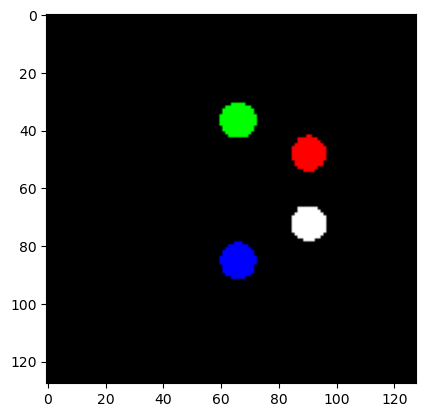

In [102]:
plt.imshow((image[1].permute(1,2,0)).byte())

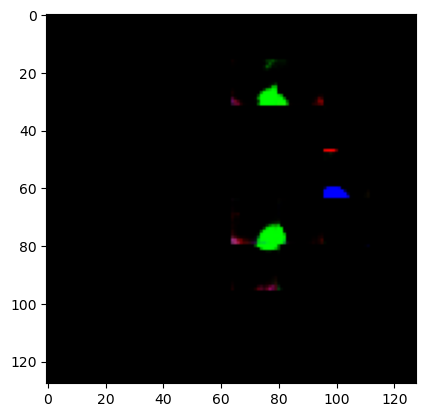

In [103]:
plt.imshow((dyn_recons_image[0].permute(1,2,0)*255).byte())


torch.Size([64, 16, 16, 3])


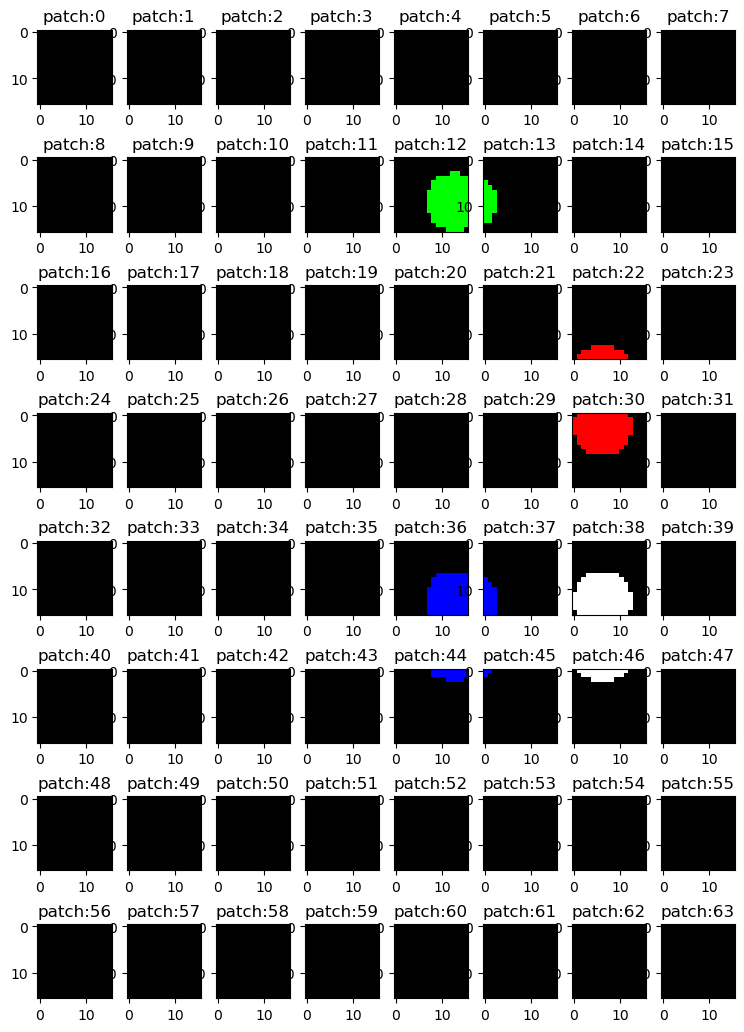

In [104]:
plot_image_patches(image[0], patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);

torch.Size([64, 16, 16, 3])


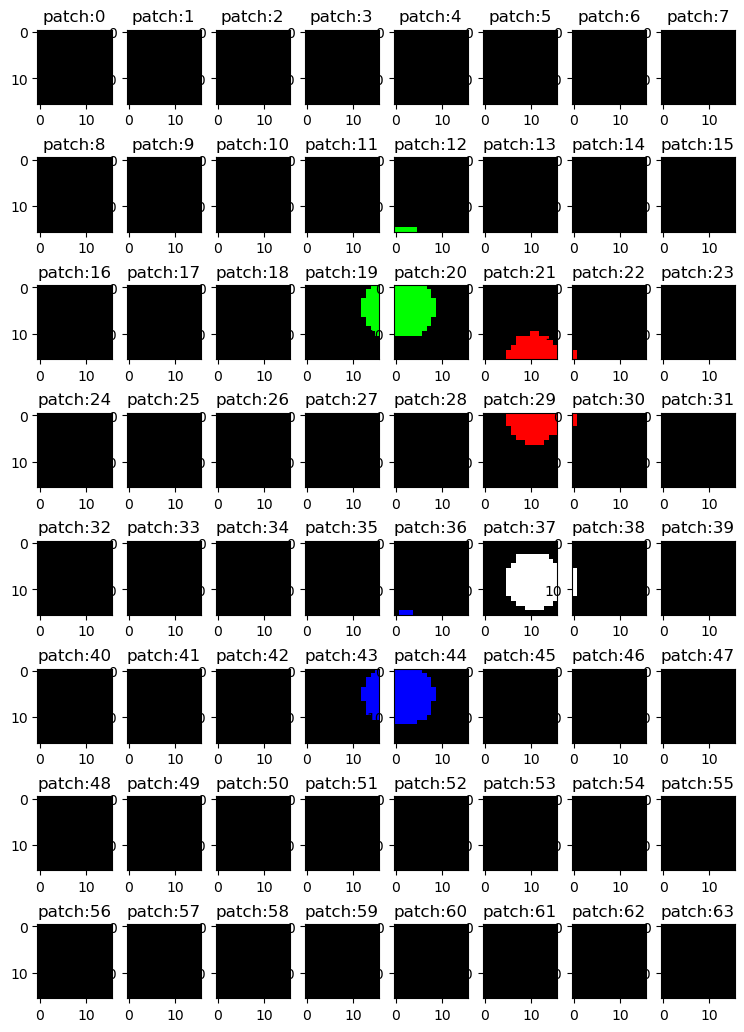

In [105]:
plot_image_patches(image[1], patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);

torch.Size([64, 16, 16, 3])


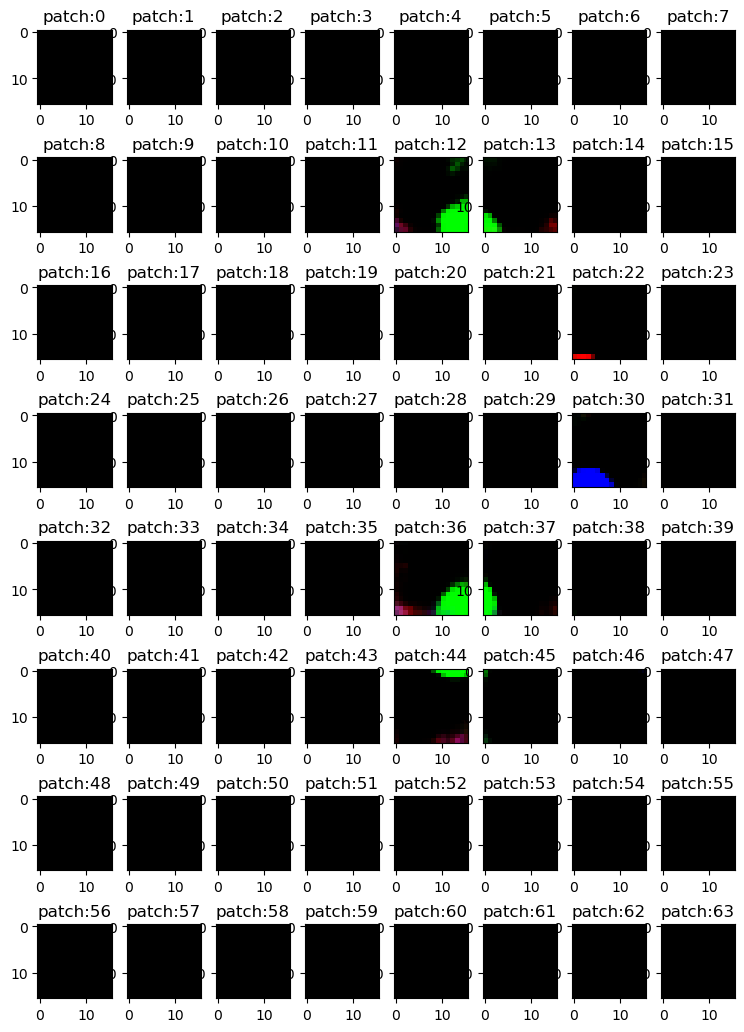

In [106]:
plot_image_patches(dyn_recons_image[0]*255, patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);

In [107]:
gt_mask = make_gt_causal_mask(image[0].unsqueeze(0),action[0],image[1].unsqueeze(0),patch_size=16,num_sprites=4)


In [108]:
patch_slice = (8,28)

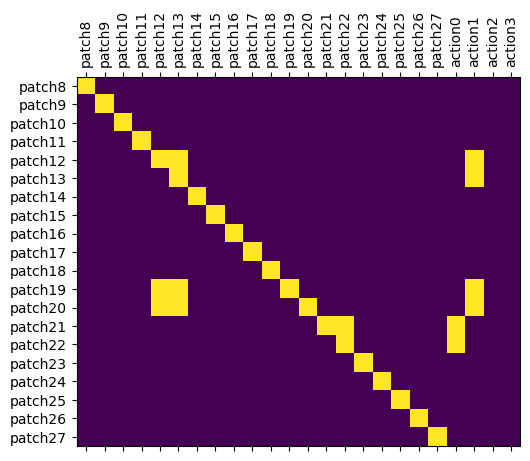

In [109]:
plot_mask(gt_mask[0].detach(),patch_slice=patch_slice)

In [110]:
causal_mask, attention_weights = dynamics_model.get_causal_mask((image/255.), action,encoder=enc_dec,head_fusion="max",discard_ratio=0.9)



In [111]:
attn_layer = aggreg_heads(attention_weights[0,0],head_fusion="max")

In [112]:
from src.mask_utils import attn_rollout

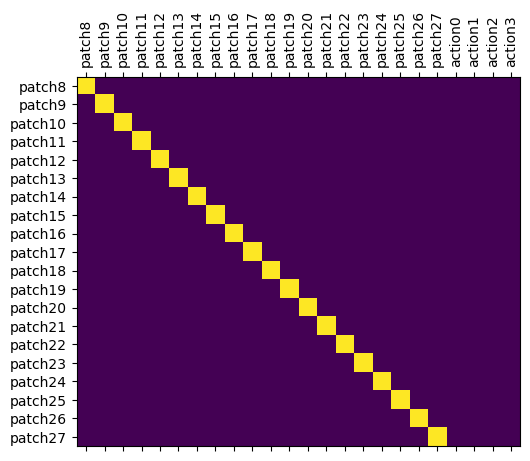

In [113]:
plot_mask( causal_mask[0].detach() > 0.3, patch_slice=patch_slice)



In [56]:
attention_weights = dynamics_model.get_attn_weights(image/255., action,encoder=enc_dec)


In [51]:
attention_weights.shape

torch.Size([5, 1, 3, 68, 68])

In [52]:
plot_mask(attention_weights[0,0,3].detach(),patch_slice=patch_slice)


IndexError: index 3 is out of bounds for dimension 2 with size 3

In [53]:
attention_weights.shape

torch.Size([5, 1, 3, 68, 68])

In [54]:
mult = attention_weights.prod(axis=2)

In [ ]:
mult.shape

torch.Size([5, 1, 68, 68])

In [ ]:
rep_attn = attention_weights.repeat(1,1,1,1,1)

In [ ]:
def coda_images(t1,t2,encoder,dynamics):
    with torch.no_grad():
        image1, action1 = t1
        mask1,_ = dynamics.get_causal_mask(image1/255., action1,encoder=encoder,head_fusion="max",discard_ratio=0.98)

        image2, action2 = t2
        mask2,_ = dynamics.get_causal_mask(image2/255., action2,encoder=encoder,head_fusion="max",discard_ratio=0.98)
    
    mask1 = mask1.cpu().numpy().transpose(0,2,1)[0]
    mask2 = mask2.cpu().numpy().transpose(0,2,1)[0]
    
    t1_sa = np.arange(mask1.shape[0])
    t1_s2 = np.arange(mask1.shape[0] - action1.shape[1])
    
    t2_sa = np.arange(mask2.shape[0])
    t2_s2 = np.arange(mask2.shape[0] - action2.shape[1])
    
    t1 = (t1_sa,t1_s2)
    t2 = (t2_sa,t2_s2)
    res = transitions_and_masks_to_proposals(t1,
                                       t2,
                                       mask1,
                                       mask2,
                                       max_samples=10,
                                       max_ccs=20)
    
    
    
    

    

In [ ]:
t1_idx = 95
t2_idx = 127


torch.Size([64, 16, 16, 3])


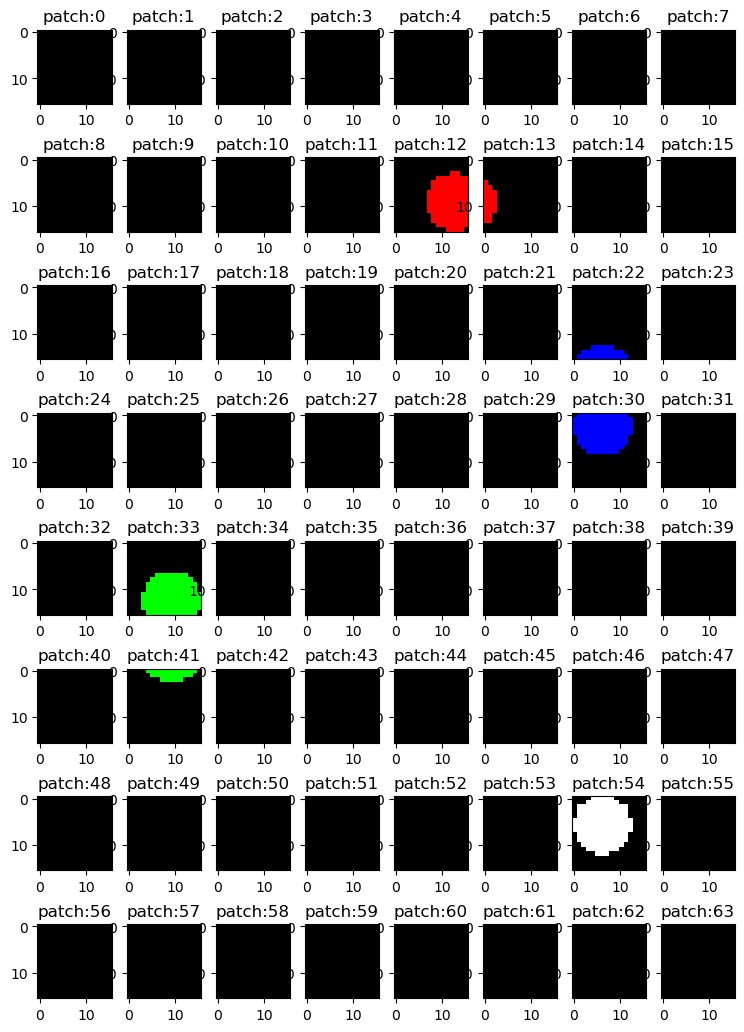

In [ ]:
plot_image_patches(dataset[t1_idx][0][0], patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);


torch.Size([64, 16, 16, 3])


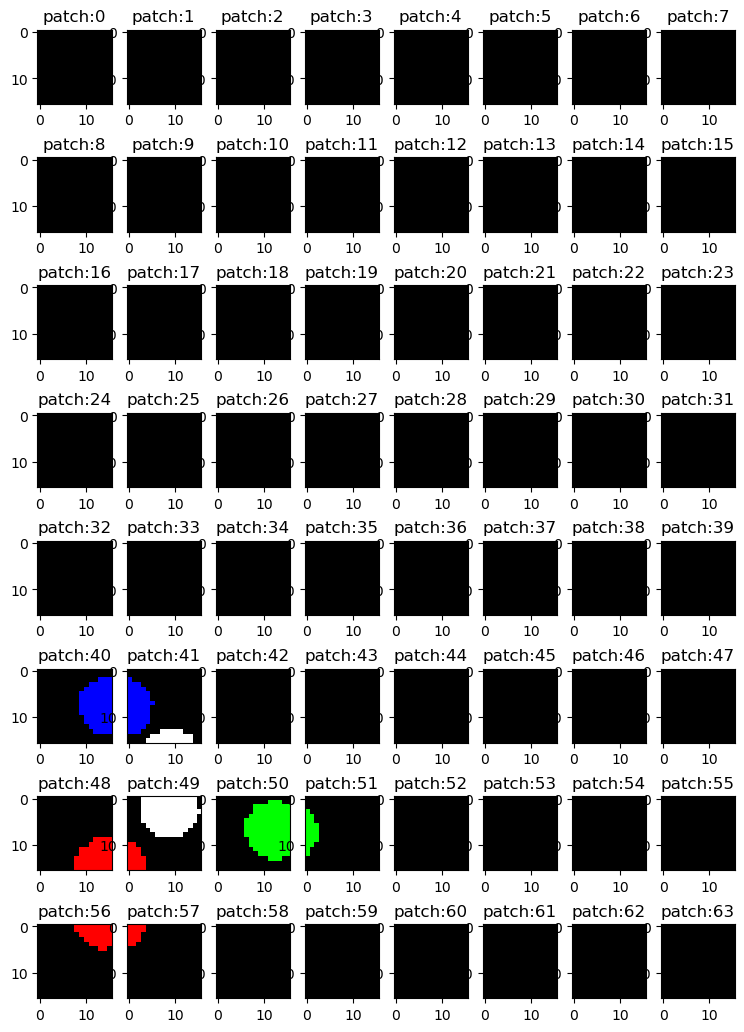

In [ ]:
plot_image_patches(dataset[t2_idx][0][0], patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);


In [ ]:


def swap_transition_components(patches1,patches2, action1,action2, next_patches1, next_patches2, cc1_to_swap,cc2_to_swap):
    
    swapped_patches = []
    swapped_actions = []
    swapped_next_patches = []
    for cc1,cc2 in zip(cc1_to_swap,cc2_to_swap):
        
        # swap actions
        new_action1 = action1.clone()
        new_action2 = action2.clone()
        action1_idx = [act - patches1.shape[0] for act in cc1["actions"]]
        action2_idx = [act - patches1.shape[0] for act in cc2["actions"]]
        
        new_action1[action1_idx] = action2[action2_idx]
        new_action2[action2_idx] = action1[action1_idx]
        
        swapped_actions.append(new_action1)
        swapped_actions.append(new_action2)
        
        cc1_wo_act = cc1["patches"]
        cc2_wo_act = cc2["patches"]
        
        # swap current image patches
        new_patches1 = patches1.clone()
        new_patches2 = patches2.clone()
        
        new_patches1[cc1_wo_act], new_patches1[cc2_wo_act] = patches2[cc1_wo_act], patches2[cc2_wo_act]
        swapped_patches.append(new_patches1)
        new_patches2[cc1_wo_act], new_patches2[cc2_wo_act] = patches1[cc1_wo_act], patches1[cc2_wo_act]
        swapped_patches.append(new_patches2)

        # swap next image patches
        new_next_patches1 = next_patches1.clone()
        new_next_patches2 = next_patches2.clone()
        new_next_patches1[cc1_wo_act], new_next_patches1[cc2_wo_act] = next_patches2[cc1_wo_act], next_patches2[cc2_wo_act]
        swapped_next_patches.append(new_next_patches1)
        new_next_patches2[cc1_wo_act], new_next_patches2[cc2_wo_act] = next_patches2[cc1_wo_act], next_patches2[cc2_wo_act]
        swapped_next_patches.append(new_patches2)

    return swapped_patches, swapped_actions, swapped_next_patches
        

def get_ccs_to_swap(m1,m2,num_actions):
    cc1 = get_cc_dicts_from_mask(m1,num_patches=m1.shape[0]-num_actions,num_actions=num_actions)    
    cc2 = get_cc_dicts_from_mask(m2,num_patches=m1.shape[0]-num_actions,num_actions=num_actions)   
    
    num_patches = m1.shape[0] - num_actions
    
    action_ccs1 = [cc for cc in cc1 if len(cc["actions"]) > 0]
    action_ccs2 = [cc for cc in cc2 if len(cc["actions"]) > 0]
    
    print("action_ccs1",action_ccs1)
    print("action_ccs2",action_ccs2)
    ccs1_to_swap = []
    ccs2_to_swap = []
    for act_cc1 in action_ccs1:
        
        can_swap_cc = True
        print(act_cc1)
        if len(act_cc1["actions"]) > 1:
            can_swap_cc = False
        #if (act_cc1 > (num_patches-1)).sum() != 1:
        #    print(f"{(act_cc1> (num_patches-1)).sum()} actions in big cc" )
        #    can_swap_cc = False
            
        act_cc1_action = act_cc1["actions"][0]
        cc2_same_act = [c for c in cc2 if act_cc1_action in c["actions"]][0]
        
        if len(cc2_same_act["actions"]) > 1:
            can_swap_cc = False
        #if (cc2_same_act > (num_patches-1)).sum() != 1:
        #    print("Action of the big cc1 is in connected component of more than one action in cc2 ")
        #    can_swap_cc = False

        cc1_wo_action_cc = remove_component_with_action(act_cc1_action,cc1)
        for c in cc2_same_act["patches"]:
            if not indep_comp_in_other(c,cc1_wo_action_cc):      
                print("Component of cc2 with same action as big cc1 is not independent in cc1")
                can_swap_cc = False

        cc2_wo_action = remove_component_with_action(act_cc1_action,cc2)
        for c in act_cc1["patches"]:
            if not indep_comp_in_other(c,cc2_wo_action):      
                print("not indep")
                can_swap_cc = False 
                
        if not can_swap_cc:
            continue
        print("We can swap the patches")
        ccs1_to_swap.append(act_cc1)
        ccs2_to_swap.append(cc2_same_act)

    return ccs1_to_swap, ccs2_to_swap


def get_transition_data(dataset, t_idx,use_gt_mask,encoder=None,dynamics=None,patch_size=16,num_actions=4):
    image, action, next_image = dataset[t_idx][0], dataset[t_idx][1],dataset[t_idx][2]
    image = image[0]
    next_image = next_image[0]
    action = action[0]
    if use_gt_mask:
        images = torch.stack([image,next_image])
        mask = make_gt_causal_mask(images.unsqueeze(0),action.unsqueeze(0),
                                   patch_size=patch_size,num_sprites=num_actions)
    else:
        mask, _ = dynamics.get_causal_mask(image.unsqueeze(0)/255., action.unsqueeze(0),encoder=encoder,head_fusion="max",discard_ratio=0.98)
        mask = mask > 0.2
    mask = mask.cpu().numpy().transpose(0,2,1)[0]
    
    return image, action, next_image, mask    
    
    
def do_coda_on_transition(dataset, t1_idx, t2_idx, patch_size,num_actions,use_gt_mask,encoder=None,dynamics=None):
    
    image1, action1, next_image1, mask1 = get_transition_data(dataset, t1_idx,use_gt_mask=use_gt_mask,encoder=encoder,dynamics=dynamics,patch_size=patch_size,num_actions=num_actions)    
    image2, action2, next_image2, mask2 = get_transition_data(dataset, t2_idx,use_gt_mask=use_gt_mask,encoder=encoder,dynamics=dynamics,patch_size=patch_size,num_actions=num_actions)
        
    patches1 = image_to_patches(image1, patch_size=(patch_size,patch_size),num_patches_sqrt=image1.shape[2]//patch_size)
    patches2 = image_to_patches(image2, patch_size=(patch_size,patch_size),num_patches_sqrt=image2.shape[2]//patch_size)

    next_patches1 = image_to_patches(next_image1, patch_size=(patch_size,patch_size),num_patches_sqrt=image1.shape[2]//patch_size)
    next_patches2 = image_to_patches(next_image2, patch_size=(patch_size,patch_size),num_patches_sqrt=image2.shape[2]//patch_size)

    comp_to_swap_ccs1, comp_to_swap_ccs2 = get_ccs_to_swap(mask1,mask2,num_actions)
    
    coda_transitions = swap_transition_components(patches1,patches2, action1,action2, next_patches1, next_patches2, 
                                        comp_to_swap_ccs1,comp_to_swap_ccs2)
    
    
    return coda_transitions

    

In [ ]:
gt_swapped_patches, swapped_actions, swapped_next_patches = do_coda_on_transition(dataset,t1_idx,t2_idx,16,4,use_gt_mask=True,encoder=None,dynamics=None)


TypeError: make_gt_causal_mask() missing 1 required positional argument: 'next_image'

In [ ]:
print("GT swapped patches",len(gt_swapped_patches))

In [ ]:
coda_images = patches_to_image(torch.stack(gt_swapped_patches),patch_size=16,image_size=128)


In [ ]:
plt.imshow(dataset[t1_idx][0][0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(dataset[t2_idx][0][0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(coda_images[1].permute(1,2,0))

In [ ]:
swapped_patches, swapped_actions, swapped_next_patches = do_coda_on_transition(dataset,t1_idx,t2_idx,16,4,use_gt_mask=False,encoder=enc_dec,dynamics=dynamics_model)



In [ ]:
len(swapped_patches)


In [ ]:
coda_images = patches_to_image(torch.stack(swapped_patches),patch_size=16,image_size=128)


In [ ]:
coda_next_images = patches_to_image(torch.stack(swapped_next_patches),patch_size=16,image_size=128)

In [ ]:
plt.imshow(dataset[t1_idx][0][0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(dataset[t2_idx][0][0].permute(1,2,0).cpu().numpy())

In [ ]:
plt.imshow(coda_images[1].permute(1,2,0))

In [ ]:
plt.imshow(coda_next_images[0].permute(1,2,0))

In [ ]:
max_samples = 100

print("created disconnected components")
# get shared connected components in random order
shared_dc = list(dc1.intersection(dc2))
random.shuffle(shared_dc)

# subsample shared_dc down to max_samples
if len(shared_dc) > max_samples:
    shared_dc = shared_dc[:max_samples]

#print("shared_dc", shared_dc)
all_idxs = set(range(len(sa1)))

res = []
for dc in shared_dc:
    not_dc = list(all_idxs - set(dc))
    dc = list(dc) # (0, 2)

    print(len(dc))
    proposed_sa = np.zeros_like(sa1)
    proposed_s2 = np.zeros_like(sa1)

    proposed_sa[dc]     = sa1[dc]
    proposed_sa[not_dc] = sa2[not_dc]
    proposed_s2[dc]     = s21[dc]
    proposed_s2[not_dc] = s22[not_dc]

    print(proposed_sa)
    proposed_t = (proposed_sa, proposed_s2)
    res.append((proposed_t, tuple(dc)))


In [ ]:

# get_dcs_from_mask should return a set of tuples of indices, inc. the empty tuple
# where the subgraph represented by each tuple is disconnected from the result of 
# the graph. Note that mask should be square, so columns corresp. to action idxs are 
# dummy columns.
#
# E.g., if mask is [[1,0,0,0],[0,1,0,0],[0,0,1,1],[0,0,1,1]],
# this function should return:
#   set([ (,), (0,), (1,), (0,1), (2, 3), (0, 2, 3), (1, 2, 3), (0, 1, 2, 3)  ])

print("creating disconnected components")
dc1 = get_dcs_from_mask(m1, max_ccs)
dc2 = get_dcs_from_mask(m2, max_ccs)

In [ ]:
def keep_n_patches(transition, mask,num_patches_keep, num_actions=4):
    t_s1a = transition[0]
    t_s2  = transition[1]
    
    t_s1a_n = np.hstack((t_s1a[:num_patches_keep],t_s1a[-num_actions:]))
    t_s2_n = np.hstack((t_s2[:num_patches_keep],t_s2[-num_actions:]))
    mask_n_top =  np.hstack((mask[:num_patches_keep,:num_patches_keep],mask[:num_patches_keep, -num_actions:] ))
    mask_n_bot = np.hstack((mask[-num_actions:,:num_patches_keep],mask[-num_actions:, -num_actions:] ))
    mask_n = np.vstack((mask_n_top,mask_n_bot))
    return (t_s1a_n, t_s2_n), mask_n


def keep_trans_slice(transition, mask,slice_keep, num_actions=4):
    ## here the states and actions are just the indices
    assert slice_keep[-1] <= (mask.shape[0] - num_actions)
    
    t_s1a = transition[0]
    t_s2  = transition[1]

    t_s1a_n = np.hstack((t_s1a[slice_keep[0]:slice_keep[1]],t_s1a[-num_actions:]))
    t_s2_n = np.hstack((t_s2[slice_keep[0]:slice_keep[1]],t_s2[-num_actions:]))
    mask_n_top =  np.hstack((mask[slice_keep[0]:slice_keep[1],slice_keep[0]:slice_keep[1]],mask[slice_keep[0]:slice_keep[1], -num_actions:] ))
    mask_n_bot = np.hstack((mask[-num_actions:,slice_keep[0]:slice_keep[1]],mask[-num_actions:, -num_actions:] ))
    mask_n = np.vstack((mask_n_top,mask_n_bot))
    return (t_s1a_n, t_s2_n), mask_n
    
    
def make_trans_coda(dataset, t_idx1, t_idx2,encoder,dynamics):
    image1, action1 = dataset[t_idx1][0], dataset[t_idx1][1]
    image2, action2 = dataset[t_idx2][0], dataset[t_idx2][1]
    with torch.no_grad():
        image1, action1 = t1
        mask1,_ = dynamics.get_causal_mask(image1/255., action1,encoder=encoder,head_fusion="max",discard_ratio=0.98)

        image2, action2 = t2
        mask2,_ = dynamics.get_causal_mask(image2/255., action2,encoder=encoder,head_fusion="max",discard_ratio=0.98)

    m1 = mask1.cpu().numpy().transpose(0,2,1)[0]
    m2 = mask2.cpu().numpy().transpose(0,2,1)[0]

    t1_sa = np.arange(mask1.shape[0])
    t1_s2 = np.arange(mask1.shape[0])

    t2_sa = np.arange(mask2.shape[0])
    t2_s2 = np.arange(mask2.shape[0])

    t1 = (t1_sa,t1_s2)
    t2 = (t2_sa,t2_s2)
    return (t1,m1), (t2,m2)


def swap_transitions(patches_image1_s1,action1,patches_image1_s2,patches_image2_s1,action2,patches_image2_s2,t2_to_t1):
    patches_image1_s1 = patches_image1_s1.clone()
    action1 = action1.clone()
    patches_image1_s2 = patches_image1_s2.clone()
    patches_image1_s1[t2_to_t1] = patches_image2_s1[t2_to_t1]
    action1[t2_to_t1] = action2[t2_to_t1]
    patches_image1_s2[t2_to_t1] = patches_image2_s2[t2_to_t1]
    
    return patches_image1_s1,action1, patches_image1_s2

def do_coda(dataset,
            t_idx1,
            t_idx2,
            encoder,
            dynamics,
            num_patches_keep=16,
            ground_truth_mask=False,
            max_samples=100):
    
    
    image1_s1, action1 = dataset[t_idx1][0], dataset[t_idx1][1]
    image1_s2 = dataset[t_idx1+1][0] # need to check if sequence ended or not
    image2_s1, action2 = dataset[t_idx2][0], dataset[t_idx2][1]
    image2_s2 = dataset[t_idx2+1][0]
    
    
    image1_s1_patches = image_to_patches(image1_s1,patch_size=16,num_patches_sqrt=8)
    image2_s1_patches = image_to_patches(image2_s1,patch_size=16,num_patches_sqrt=8)
    
    image1_s2_patches = image_to_patches(image1_s2,patch_size=16,num_patches_sqrt=8)
    image2_s2_patches = image_to_patches(image2_s2,patch_size=16,num_patches_sqrt=8)
    
    if ground_truth_mask:
        t1m1, t2m2 = make_gt_trans_coda(dataset, t_idx1, t_idx2)
    else:
        t1m1, t2m2 = make_trans_coda(dataset, t_idx1, t_idx2,encoder,dynamics)
    
    t1 = t1m1[0]
    m1 = t1m1[1]
    t2 = t2m2[0]
    m2 = t2m2[1]
    num_iter = (m1.shape[0] - dynamics.action_embedding.num_actions)//num_patches_keep
    
    coda_images = []
    coda_actions = []
    for i in range(num_iter):
        t1_n, mask1_n = keep_trans_slice(t1, m1,num_patches_keep)
        t2_n, mask2_n = keep_trans_slice(t2, m2,num_patches_keep) 
        dcs = get_dcs(mask1_n,mask2_n,max_ccs=num_patches_keep,max_samples=max_samples)    
        coda_images_part = []
        coda_actions_part = []
        for (dc,not_dc) in dcs:
            new_s1, new_action1, new_s2 = swap_transitions(image1_s1_patches,action1,image1_s2_patches,image2_s1_patches,action2,image2_s2_patches,dc,not_dc)
            coda_images_part.append(torch.stack([new_s1,new_s2]))
            coda_actions_part.append(torch.stack([new_action1]))
            
        coda_images_part = torch.stack(coda_images_part)
        
        max_coda_diff_idx = (image1_s1_patches - coda_images_part[:,0]).abs().sum(axis=(1,2,3)).argmax()
        
        coda_images.append(coda_images_part[max_coda_diff_idx])
        coda_actions.append(coda_actions_part[max_coda_diff_idx])
        
    return coda_images[:,0], coda_actions, coda_images[:,1]
            
            
def get_dcs(m1,m2,max_ccs=16,max_samples=100):
    dc1 = get_dcs_from_mask(m1, max_ccs)
    dc2 = get_dcs_from_mask(m2, max_ccs)
    shared_dc = list(dc1.intersection(dc2))
    random.shuffle(shared_dc)

    # subsample shared_dc down to max_samples
    if len(shared_dc) > max_samples:
        shared_dc = shared_dc[:max_samples]
    all_idxs = set(range(len(m1.shape[0])))

    res = []
    for dc in shared_dc:
        not_dc = list(all_idxs - set(dc))
        dc = list(dc) # (0, 2)
        res.append((tuple(dc), tuple(not_dc)))
        
    return res



In [ ]:
coda_act = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/coda_act.pt")
coda_obs = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/coda_obs.pt")
coda_next_obs = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/coda_next_obs.pt")



In [ ]:
act = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/act.pt")
obs = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/obs.pt")
next_obs = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/next_obs.pt")
rewards = torch.load("/cluster/home/gboeshertz/patch_rl/outputs/train_agent/4/2022.12.07/141030/rewards.pt")


In [ ]:
plt.imshow(obs[90,0].numpy().transpose(1,2,0))


In [ ]:
plt.imshow(coda_obs[10,0].transpose(1,2,0))

In [ ]:
rewards.sum()

In [ ]:
from src.mask_utils import get_cc_dicts_from_mask,get_cc_from_mask,get_ccs_to_swap,swap_transition_components

In [ ]:
import torch
import gym
import hydra
from moog import environment
from moog.env_wrappers import gym_wrapper
from moog_demos.example_configs import bouncing_sprites
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.logger import configure
from src.mask_utils import make_gt_causal_mask, get_cc_dicts_from_mask, gt_reward_function
from omegaconf import OmegaConf
import os 
import wandb
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.logger import configure
from src.networks.cnns import Conv2dModel
import d3rlpy
import logging
from tensorboard.util import tb_logging
import wandb
from src.coda_dataset import CodaDataset
from src.datasets import ImageTransitionDataset
from src.d3rl_feature_extractor import PatchCNNFactory, PatchVAEFactory
from hydra.utils import get_original_cwd, to_absolute_path
import numpy as np
from d3rlpy.metrics.scorer import initial_state_value_estimation_scorer


class _IgnoreTensorboardPathNotFound(logging.Filter):
    def filter(self, record):
        assert record.name == "tensorboard"
        if "No path found after" in record.msg:
            return False
        return True


class ImageReshaper(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageReshaper, self).__init__(env)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(3, 128, 128), dtype=np.uint8)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)

def make_mask_function(image,action,next_image,  encoder=None,dynamics=None, make_gt_mask=False,patch_size=16, num_sprites=4):
    
    if make_gt_mask:
        mask = make_gt_causal_mask(image, action, next_image, num_sprites=num_sprites,patch_size=patch_size[0])
    else:
        assert encoder is not None
        mask = dynamics.get_causal_mask(image, action,encoder=encoder, discard_ratio=0.95,head_fusion=dynamics.head_fusion)
    return mask

def make_reward_function(image, action, next_image, encoder=None,dynamics=None,make_gt_reward=False):    
    
    if make_gt_reward:
        rewards = gt_reward_function(image,next_image)
    else:
        assert encoder is not None
        rewards = dynamics.get_rewards(image, action,encoder=encoder)
    return rewards


def setup_dataset(config,env):

    coda_data_path = f"..{config.coda_dataset_path}"
    
    if config.load_dataset:
        print(f"Loading dataset from {coda_data_path}")
        coda_dataset = ImageTransitionDataset(coda_data_path)
    else:
        encoder_decoder = dynamics_model = None

        mask_function = lambda image, next_image, action: make_mask_function(image, next_image,action, encoder=encoder_decoder,dynamics=dynamics_model, make_gt_mask=config.dataset.use_gt_mask,patch_size=config.dataset.patch_size, num_sprites=4)
        reward_function = lambda image, action, next_image: make_reward_function(image, action,next_image, encoder=encoder_decoder,dynamics=dynamics_model,make_gt_reward=config.dataset.use_gt_reward)

        data_path = f"..{config.dataset_path}"
        dataset = ImageTransitionDataset(data_path)
        print("Creating CoDA data")
        coda_dataset = CodaDataset(dataset,max_coda_transitions=config.dataset.max_coda_transitions ,mask_function=mask_function,
                                   reward_function=reward_function, patch_size=config.dataset.patch_size,
                                   num_actions=env.action_space._shape[0],num_patches=config.dataset.num_patches)
        if config.dataset.save_coda_dataset:
            coda_dataset.save(coda_data_path)
            
    return coda_dataset



In [ ]:
config = OmegaConf.load("configs/train_batch_agent.yaml")

In [ ]:
eval_env_config = bouncing_sprites.get_config(num_sprites=4,is_demo=False,
                                                        timeout_steps=100, 
                                                        contact_reward=True,
                                                        one_sprite_mover=False,
                                                        all_sprite_mover=True,
                                                        discrete_all_sprite_mover=False,
                                                        random_init_places=True,
                                                        visual_obs = True,
                                                        instant_move = True,
                                                        action_scale=0.05,
                                                        seed=0+10,
                                                        disappear_after_contact=True,
                                                        dont_show_targets=True)

eval_env = environment.Environment(**eval_env_config)
eval_env = ImageReshaper(gym_wrapper.GymWrapper(eval_env))


Using bouncing ball environment with 4 sprites
<PIL.Image.Image image mode=RGB size=128x128 at 0x2AB83A8827C0>


In [ ]:
eval_env.action_space

spec BoundedArray(shape=(8,), dtype=dtype('float32'), name=None, minimum=-1.0, maximum=1.0)


/cluster/home/gboeshertz/miniconda3/envs/urlb/lib/python3.8/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Box([-1. -1. -1. -1. -1. -1. -1. -1.], [1. 1. 1. 1. 1. 1. 1. 1.], (8,), float32)

In [ ]:
encoder_decoder = dynamics_model = None

mask_function = lambda image, next_image, action: make_mask_function(image, next_image,action, encoder=encoder_decoder,dynamics=dynamics_model, make_gt_mask=config.dataset.use_gt_mask,patch_size=config.dataset.patch_size, num_sprites=4)
reward_function = lambda image, action, next_image: make_reward_function(image, action,next_image, encoder=encoder_decoder,dynamics=dynamics_model,make_gt_reward=config.dataset.use_gt_reward)

data_path = f"..{config.dataset_path}"
dataset = ImageTransitionDataset(data_path)
print("Creating CoDA data")
coda_dataset = CodaDataset(dataset,max_coda_transitions=config.dataset.max_coda_transitions ,mask_function=mask_function,
                            reward_function=reward_function, patch_size=config.dataset.patch_size,
                            num_actions=8,num_patches=config.dataset.num_patches)


Observations shape torch.Size([5000, 3, 128, 128])
Creating CoDA data
Dataset obs max tensor(255.)
Dataset obs min tensor(0.)
Dataset obs mean tensor(1.6589)
Dataset obs std tensor(20.5003)
Masks shape: torch.Size([5000, 68, 68])
Coda observations shape:  torch.Size([8, 3, 128, 128])
Coda rewards shape:  torch.Size([8])
Time to do coda 0.026158809661865234
torch.uint8


: 

: 

In [ ]:


def n_transition_list(dataset,n_transitions):
    
    transition_list = []
    
    n_obs = dataset.observations[:n_transitions].numpy()
    n_actions = dataset.actions[:n_transitions].numpy()
    n_next_obs = dataset.next_observations[:n_transitions].numpy()
    n_rewards = dataset.rewards[:n_transitions].numpy()
    n_dones = dataset.dones[:n_transitions].numpy()

    if np.isnan(n_obs).any():
        print("Nan in obs")
    if np.isnan(n_actions).any():
        print("Nan in actions")
    if np.isnan(n_next_obs).any():
        print("Nan in obs")
    if np.isnan(n_rewards).any():
        print("Nan in rewards")
    if np.isnan(n_dones).any():
        print("Nan in n_dones")

    print(f"n_obs shape: {n_obs.shape}")
    print("Observations stats: ",np.min(n_obs),np.max(n_obs),np.mean(n_obs),np.std(n_obs))
    print("Next observations stats: ",np.min(n_next_obs),np.max(n_next_obs),np.mean(n_next_obs),np.std(n_next_obs))
    print("Rewards stats: ",np.min(n_rewards),np.max(n_rewards),np.mean(n_rewards),np.std(n_rewards))
    print("Actions stats: ",np.min(n_actions),np.max(n_actions),np.mean(n_actions),np.std(n_actions))

    terminals = n_dones * (n_rewards>0)
    print("Terminal stats: ",np.min(terminals),np.max(terminals),np.mean(terminals),np.std(terminals))
    for i in range(0,n_obs.shape[0]):
        trans = d3rlpy.dataset.Transition(observation_shape=list(n_obs[i].shape),
                                          action_size=n_actions[i].shape[0],
                                          observation=n_obs[i].astype(np.uint8),
                                          action=n_actions[i].astype(np.float32),
                                          reward= float(n_rewards[i]),
                                          next_observation=n_next_obs[i].astype(np.uint8),
                                          terminal= float(terminals[i]))
        transition_list.append(trans)
    
    print(f"Transition list length: {len(transition_list)}")
    return transition_list

In [ ]:
coda_dataset.dones.dtype

In [ ]:
(coda_dataset.dones * (coda_dataset.rewards>0))

In [ ]:
obs = eval_env.reset()

In [ ]:
n_list = n_transition_list(dataset,5000)
c_list = n_transition_list(coda_dataset,5000)

In [ ]:
from src.mask_utils import gt_count_function

In [ ]:
config = OmegaConf.load("configs/train_batch_agent.yaml")

In [ ]:

dataset = setup_dataset(config,eval_env)

In [ ]:
for i in range(5):
    print("Image ",i)
    img_idx = np.random.choice(100,1)
    img = dataset.observations[img_idx[0]]
    print("Image shape",img.shape)
    print("GT count",gt_count_function(img.unsqueeze(0),4))

    plt.imshow(img.permute(1,2,0))
    plt.show()
    

In [ ]:

e = torch.ones(4,4).type(torch.uint8)
e[0,0]= 255
f = torch.ones(2,4).float()
f[1,1] = 256


In [ ]:
c = torch.cat((e,f),dim=0)

In [ ]:
c

tensor([[255.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1.,   1.,   1.,   1.],
        [  1., 256.,   1.,   1.]])